# Codeacademy Final Portfolio Project # 
## Amazon Fine Food Reviews ##

Being frequent Amazon user, food lover, and data science enthusiast, I decided to analyze Amazon fine foods review dataset.  My work focuses on analysis of top scored and most comented products, shows the increase of Amazon popularity over years, and  on building prediction model using natural language processing. Data is taken from Kaggle : [Amazon Fine Food Reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews), however it comes originaly from  [Stanford Network Analysis Project (SNAP)](https://snap.stanford.edu/data/web-FineFoods.html).
Project sections following:

* [Exploratory Data Analysis](#EDA)
* [Label Balance in Data Set](#balanceCheck)
* [Data Preparation](#dataPrep)
* [Checking common words per class](#wordCloud) 
* [Text Transformation to Vectors](#textTrans)
* [Building ML Model](#model)
* [Rebalancing the Data Set](#resample)
* [Alternative Classification Model](#altModel)
* [Next Steps](#next)



#### Column Information ####

- Id - unique identifier
- ProductId — unique identifier for the product
- UserId — unqiue identifier for the user
- ProfileName - profile name 
- Helpfulness Numerator — number of users who found the review helpful
- HelpfullnessDenominator — number of users who indicated whether they found the review helpful or not
- Score — rating between 1 and 5
- Time — timestamp for the review
- Summary — brief summary of the review
- Text — text of the review

### Objective ###

Goal is to analyze, prepare the data and to build model which should predict  the score of product by processing text in  review and Summary columns.

In [1]:
#import libraries
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Exploratory Data Analysis <a class="anchor" id="EDA"></a>

#### Loading the data ####

In [2]:
amazon = pd.read_csv('Reviews.csv')
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print(amazon.shape)
print(amazon.info())

(568454, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None


Time stamp columns will be transformed to Unix time to actual time:

In [3]:
#converting the Time columns
import datetime
amazon['Time'] = pd.to_datetime(amazon['Time'], unit='s')
amazon['Time'].describe()


count                  568454
unique                   3168
top       2012-10-16 00:00:00
freq                     1143
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: Time, dtype: object

Customer reviews are from October 1999 till October 2012 

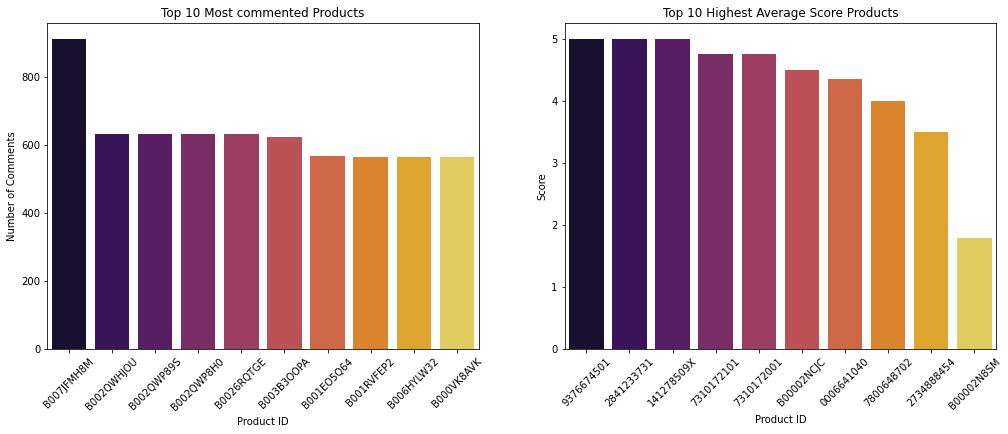

In [5]:
#finding the top 10 most comented products and finding top 10 products with best score 
top_evaluated_products= amazon['ProductId'].value_counts()[:10].sort_values(ascending=False).reset_index()
top_ratings =amazon.groupby('ProductId')['Score'].mean()[:10].sort_values(ascending=False).reset_index()
f,ax = plt.subplots(1,2, figsize= (17,6))
ax[0] = sns.barplot(ax= ax[0], data = top_evaluated_products, x = top_evaluated_products.iloc[:,0], y =top_evaluated_products.iloc[:,1], palette='inferno')
ax[0].set_title('Top 10 Most commented Products')
ax[0].set_xlabel('Product ID')
ax[0].set_ylabel('Number of Comments')
ax[0].set_xticklabels(top_evaluated_products.iloc[:,0], rotation=45)

ax[1] = sns.barplot(ax=ax[1],data = top_ratings, x = top_ratings.iloc[:,0], y=top_ratings.iloc[:,1],palette='inferno' )
ax[1].set_title('Top 10 Highest Average Score Products')
ax[1].set_xticklabels(top_ratings.iloc[:,0], rotation = 45)
ax[1].set_xlabel('Product ID')
plt.show()


It seems like the most commented products are not those with best scores. 

In [4]:
amazon[amazon['ProductId']=='B007JFMH8M']['Score'].value_counts()

5    624
4    217
3     56
2     12
1      4
Name: Score, dtype: int64

Let's check relationship between HelpfullnessNominator and HelpfulnessDenominator column: As per my understanding, two colums can have either same value per observation, or HelpfulnessDenominator can be higher. We will remove the entries where is that not the case. At the end there are only two entries where Helpfulness Numerator was higher

In [5]:

amazon.drop(amazon[amazon['HelpfulnessNumerator']>amazon['HelpfulnessDenominator']].index, inplace=True)

In [35]:
print(len(amazon))

568452


As further analysis it can be checked if the average score of some products changed over years and checked the overall distribution of scores in complete dataset 

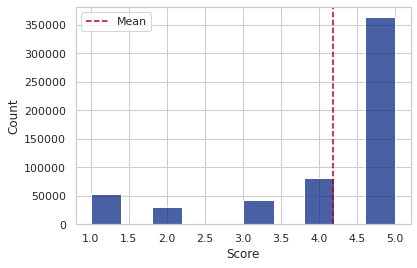

In [4]:
#overall score distribution, with mean and median
sns.set(style=('whitegrid'))
mean_score = amazon.Score.mean()
median_score = amazon.Score.median()
sns.histplot(data=amazon, x='Score',bins=10, color='#0c2c84')
plt.axvline(mean_score, color='#003049', label='Mean', linestyle = '--')
plt.legend()
plt.show()

Average score in sheet is app 4.1, majority of product reviews have score between 4.5 and 5. As per this information, majority of Amazon customers seem to be satisfied with offered products ... or this is result of boosting the sales inappropriately with fake 5-star reviews. 

In [6]:
#check scores per year : year column, average scores per year , display of results 
amazon['year'] = amazon['Time'].dt.to_period('Y')

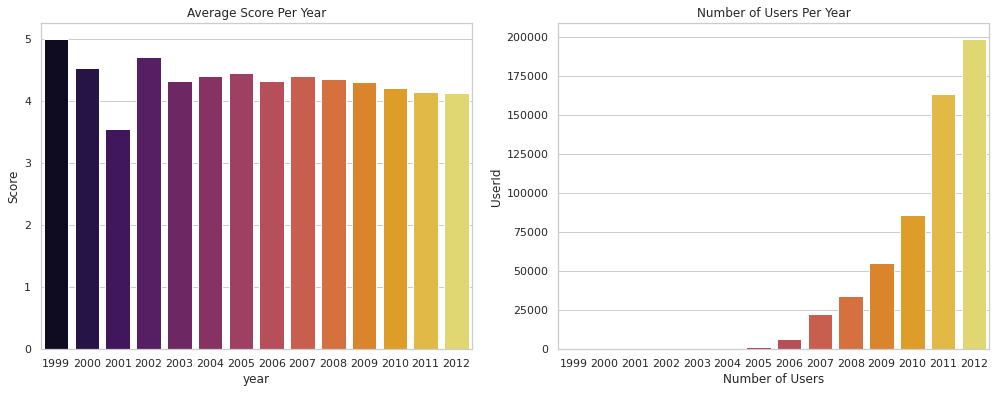

In [5]:
average_year = amazon.groupby('year')['Score'].mean().reset_index()
no_users = amazon.groupby('year')['UserId'].count().reset_index()
sns.set(style='whitegrid')
f,ax = plt.subplots(1,2, figsize=(17,6))
ax[0]= sns.barplot(ax= ax[0], data = average_year, x= average_year.iloc[:,0], y=average_year.iloc[:,1], palette ='inferno')
ax[0].set_title("Average Score Per Year")

ax[1]= sns.barplot(ax= ax[1],data= no_users, x=no_users.iloc[:,0], y= no_users.iloc[:,1], palette ='inferno')
ax[1].set_title('Number of Users Per Year')
ax[1].set_xlabel('Number of Users')
plt.show()

Number of Amazon users in this dataset drastically increased, started with 6 users in 1999, and till 2006 increased 1000 times . Average scores per year in dataset score remained stable between 4 and 5. 

In [7]:
amazon.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
year                       0
dtype: int64

### Class Balance Check <a class="anchor" id="balanceCheck"></a>

Class balance in sheet will be shown using  donut graph  

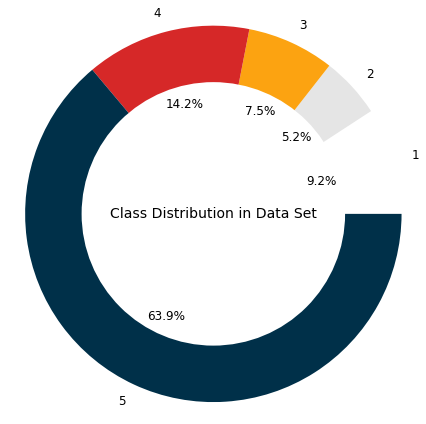

In [6]:
class_balance = amazon.groupby('Score').size().reset_index() 
pie, ax1 = plt.subplots(figsize=(6,6))
labels = class_balance.Score 
colors = ['#ffffff','#e5e5e5','#fca311', '#D62828','#003049']
ax1.pie(x = class_balance[0], autopct ="%1.1f%%", labels = labels, colors=colors, textprops = {'fontsize':12})

central_circle = plt.Circle((0,0),0.70,fc='white')
fig=plt.gcf()
fig.gca().add_artist(central_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.text(0,0,'Class Distribution in Data Set', ha='center',va='center', fontsize=14)
plt.show()
plt.show()

Data Set is very imbalanced could be that it needs to be resampled to get better model accuracy. Review with score 5 and 4 have much more examples than those with 3,2, and one.

### Data Preparation <a class="anchor" id="dataPrep"><a/>

To get more text for each label, text of the Summary column will be added to text in Text column

In [8]:
#concatinate summary and text columns
concat = amazon.Summary.str.cat(amazon.Text, join = 'outher', sep= ' ')
data = amazon['Score'].reset_index().join(concat, how='left')
data.drop(columns =['index'], inplace=True)
data.head()




,Score,Summary
0,5,Good Quality Dog Food I have bought several of...
1,1,Not as Advertised Product arrived labeled as J...
2,4,"""Delight"" says it all This is a confection tha..."
3,2,Cough Medicine If you are looking for the secr...
4,5,Great taffy Great taffy at a great price. The...


In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568452 entries, 0 to 568451
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Score    568452 non-null  int64 
 1   Summary  568423 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


#### Removing NaN entries ####

In [9]:
print(data.isnull().sum())

Score       0
Summary    29
dtype: int64


In [10]:
data.dropna(inplace=True)

In [11]:
data.isnull().sum()

Score      0
Summary    0
dtype: int64

#### Removing line break ( br ) , punctuation, special signs  ####

In [12]:
#Noise removal 
import re
data['Summary'].replace(r'<br />', ' ', regex=True, inplace=True)
data['Summary'].replace(r'http\S+', ' ', regex=True, inplace=True)
data['Summary'].replace(r'[.|,|?|"|!|#|;|)|@|&|$]', r' ', regex=True, inplace=True)


In [106]:
print(data.Summary[45])

Hearty Oatmeal This seems a little more wholesome than some of the supermarket brands  but it is somewhat mushy and doesn't have quite as much flavor either   It didn't pass muster with my kids  so I probably won't buy it again 


In [107]:
#scores = ['score1_text','score2_text', 'score3_text', 'score4_text', 'score5_text']

def score_text(s):
    x =  data[data['Score']==s]['Summary']
    j = ' '.join(x)
    return j

score_text1 = score_text(1)
#print('----')
score_text2 = score_text(2)
#print('----')
score_text3 = score_text(3)
#print('----')
score_text4 = score_text(4)
#print('----')
score_text5 = score_text(5)
#print('----')

#for score in scores:
 #   for s in range(1,6)
#         score = ''.join(data[data['Score']==s]['Summary'].tolist())


In [108]:
print(score_text3[30:1500])

ttle more wholesome than some of the supermarket brands  but it is somewhat mushy and doesn't have quite as much flavor either   It didn't pass muster with my kids  so I probably won't buy it again  Mushy The flavors are good   However  I do not see any differce between this and Oaker Oats brand - they are both mushy  Same stuff This is the same stuff you can buy at the big box stores   There is nothing healthy about it   It is just carbs and sugars   Save your money and get something that at least has some taste  not ass kickin we're used to spicy foods down here in south texas and these are not at all spicy   doubt very much habanero is used at all   could take it up a notch or two  Better price for this at Target Watch your prices with this   While the assortment was good  and I did get this on a gold box purchase  the price for this was  3-4 less at Target  How much would you pay for a bag of chocolate pretzels  If you're impulsive like me  then  6 is ok  Don't get me wrong  the qu

### Check Common Words for each Score<a class="anchor" id="wordCloud"></a>

Word Cloud will be used to show most common words per score. 

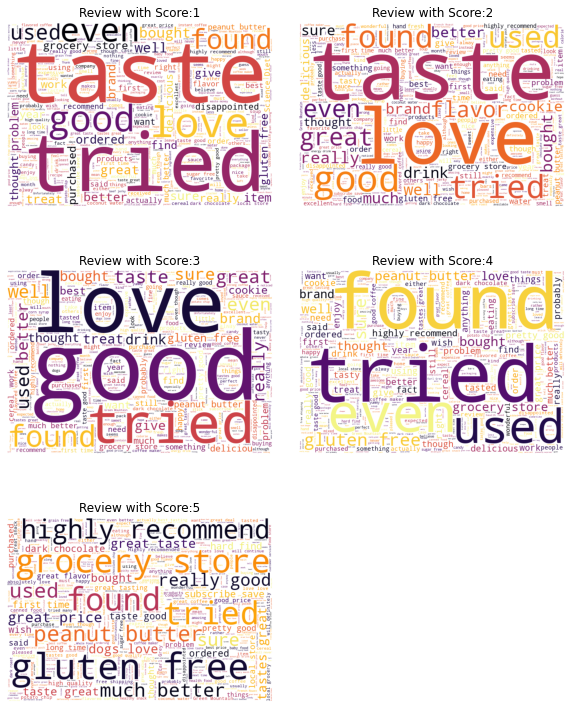

In [109]:
from wordcloud import WordCloud,STOPWORDS 
STOPWORDS.update(['product', 'stuff', 'think','amazon','thing', 'make', 'maybe', 'know' ,'made', 'seem', 'href','come', 'even'])

scores_1 = [score_text1,score_text2, score_text3, score_text4, score_text5]

plt.figure(figsize=(10,22))              
for s in scores_1:
    wc = WordCloud(height = 450, width= 650, background_color='white', max_words = 500, stopwords = STOPWORDS, min_word_length=4, collocation_threshold= 5, colormap='inferno').generate(s)
    plt.subplot(5, 2, scores_1.index(s)+1)
    plt.axis('off')
    plt.imshow(wc)
    plt.title('Review with Score:'+ str(scores_1.index(s)+1))
plt.subplots_adjust(hspace=0.2, wspace = 0.1)
plt.show()



On first sight word clouds look ok, word clouds for score from 1, till 4 seem pretty similar, there is not much difference in used words. And most of them do not seem to be informative. 
Words used for producsts with score 5 seem bit different: There are terms like 'highly recommend',  'really good' , 'much better', 'great price' and 'gluten free'. There are no words which indicate to special product, except maybe in score 5 cloud, where is 'peanut butter' one of the used words 

In [110]:
print(data.iloc[501223])

Score                                                      5
Summary    Cat seems to like it Can't give it five starts...
Name: 501250, dtype: object


In [111]:
#creating backup for reference and for further investigation
data_backup = data.to_csv(index=False)

### Text Transformation<a class="anchor" id="textTrans"><a/>

In [13]:
#not doing as is Tweets example since the numerical classification is already in the dataset
textAll = data['Summary'].tolist()
labels = data['Score'].tolist()

In [14]:
print(textAll[0:5])

['Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality  The product looks more like a stew than a processed meat and it smells better  My Labrador is finicky and she appreciates this product better than  most ', 'Not as Advertised Product arrived labeled as Jumbo Salted Peanuts   the peanuts were actually small sized unsalted  Not sure if this was an error or if the vendor intended to represent the product as  Jumbo  ', " Delight  says it all This is a confection that has been around a few centuries   It is a light  pillowy citrus gelatin with nuts - in this case Filberts  And it is cut into tiny squares and then liberally coated with powdered sugar   And it is a tiny mouthful of heaven   Not too chewy  and very flavorful   I highly recommend this yummy treat   If you are familiar with the story of C S  Lewis'  The Lion  The Witch  and The Wardrobe  - this is the treat that seduces Edmund into selling out his

In [15]:
print(len(textAll)) # text data 
print(len(labels)) # scores numbers 

568423
568423


In [16]:
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [17]:
x_train, x_test, y_train, y_test = train_test_split(textAll, labels, test_size=0.2, random_state=21, stratify = labels )

#### Transforming the text data #### 

To analyze text we first need to transform it to appropriate form - to vectorize it;  to transform collection of text documents into numerical feature vectors. CountVectorizer implements both tokenization (giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators) and occurrence counting(counting the occurrences of tokens in each document) transforms everything to lowercase, drops single letter words and punctuation (source: [Feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)) 

In [32]:

vectorizer = CountVectorizer()
#x_train_fit = vectorizer.fit(x_train)a
x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(x_test)




In [19]:
print(x_train_counts.shape)
print(x_test_counts.shape)
print(len(y_test))
print(len(x_test))

(454738, 107280)
(113685, 107280)
113685
113685


This is large document with lot of text, and with lot of words with high count - that does not necessarily mean that corresponding word is more important. Furthermore, there could be high frequency of terms which do not correlate with document topic. In order to re-weight (penalize) the dominance of frequent words, we will use tfidf, where:
- TF(term frequency: how often is term in current document) 
- IDF(Inverse Document Frequency: is a scoring of how rare the word is across documents)  

The scores have the effect of highlighting words that are distinct (contain useful information) in a given document.

Source : [A Gentle Introduction to the Bag-of-Words Model](https://machinelearningmastery.com/gentle-introduction-bag-words-model/)


In [33]:
tfidf_transformer = TfidfTransformer()
transformed_xtrain = tfidf_transformer.fit_transform(x_train_counts)
transformed_xtest = tfidf_transformer.transform(x_test_counts)

### Building The Classification Model<a class="anchor" id="model"><a/>

In [34]:

model = MultinomialNB()
model.fit(transformed_xtrain, y_train)


MultinomialNB()

In [35]:
predictions=model.predict(transformed_xtest)
print('Naive Bayes model accuracy: {}'.format(accuracy_score(y_test, predictions)))

Naive Bayes model accuracy: 0.6390992655143598


In [36]:
from sklearn.metrics import balanced_accuracy_score 
print('Balanced Accuracy Score : {}'.format(balanced_accuracy_score(y_test, predictions)))

Balanced Accuracy Score : 0.2014314141348271


In [37]:
#check classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.52      0.00      0.01     10454
           2       0.25      0.00      0.00      5953
           3       0.50      0.00      0.00      8528
           4       0.51      0.00      0.01     16131
           5       0.64      1.00      0.78     72619

    accuracy                           0.64    113685
   macro avg       0.49      0.20      0.16    113685
weighted avg       0.58      0.64      0.50    113685



Conclusions:
- Model has highest recall for the text with highest score since this class dominates the dataset . 
- Teribble recall for rest of score predictions. In all classes except class 5 number of members of a class that the classifier identified correctly divided by the total number of members in that class is 0.
- Balanced Accuracy Score is another identification of model performance, suitable for imbalanced datasets. It computes average recall per class. In this example, the usual accuracy score is much higher than the balanced one meaning that model takes advantage of imbalanced test set. 
 

### Striving for Balance<a class="anchor" id="resample"><a/> 

- When checking the values from classification report, what I can understand is that classes with scores 1,2,3 and 4 are 'minority' ones , and class with score 5 majority one (terms come from here: [learning imbalance classes](https://www.svds.com/learning-imbalanced-classes/ ))
- To balance the data I installed imblearn imbalance-learn library and will use undersampler to balance the data

In [38]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
x_train_resampled, y_train_resampled= rus.fit_resample(transformed_xtrain, y_train)

model_res= MultinomialNB()
model_res.fit(x_train_resampled, y_train_resampled)
pred = model_res.predict(transformed_xtest)
print('Naive Bayes model accuracy after undersampling: {}'.format(accuracy_score(y_test, pred)))

Naive Bayes model accuracy after undersampling: 0.34512908475172627


In [39]:
print('Balanced Accuracy Score after undersampling : {}'.format(balanced_accuracy_score(y_test, pred)))

Balanced Accuracy Score after undersampling : 0.3338938175579947


Balanced accuracy score is not much different than the conventional score

In [40]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.20      0.39      0.27     10454
           2       0.12      0.27      0.17      5953
           3       0.13      0.36      0.20      8528
           4       0.20      0.30      0.24     16131
           5       0.76      0.35      0.48     72619

    accuracy                           0.35    113685
   macro avg       0.28      0.33      0.27    113685
weighted avg       0.55      0.35      0.39    113685



- The recall for all classes looks more balanced now, the accuracy for score 5 class improved, overal accuracy decreased.
- It looks like that classes are not easy to identify, model has difficulties to distinguish statements for different score 
- After resampling model predicts smaller classes with higher accuracy but overall accuracy is less as prior resampling
- We can create confusion matrix to understand better how model works 

In [41]:
from sklearn.metrics import confusion_matrix
nbMatrix =confusion_matrix(y_test, pred)
nbLabels = model_res.classes_

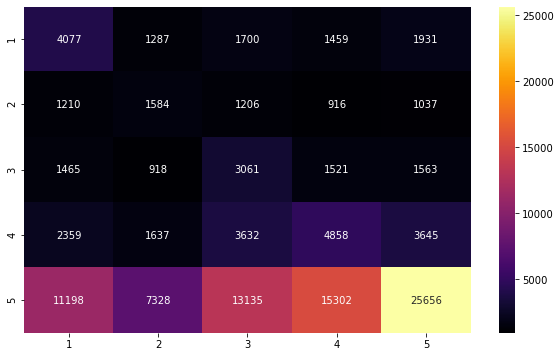

In [42]:
ax, fig = plt.subplots(figsize=(10,6))
sns.heatmap(nbMatrix, annot=True, cmap = 'inferno',fmt='d', xticklabels=nbLabels, yticklabels=nbLabels)
plt.show()

- Model classifies classes for score 4 and 5, has difficulties in distinguishing them 
- Feedback for other score is often classified as feedback for score 5
- It seems like data undersampling did not help much in overall model accuracy
- As next task for this dataset, it would be to try to predict customer feedback, and to classify it as either good or bad bad 

### SVC Alternative Classification Model<a class="anchor" id="altModel"></a>

We'll use the linear support vector classifier LinearSVC as it automatically adjusts class wieghts and uses one vs rest for handling multi-class problems.

In [43]:
from sklearn.svm import LinearSVC
classifier_l = LinearSVC(random_state=42)
classifier_l.fit(x_train_resampled, y_train_resampled)
class_pred= classifier_l.predict(transformed_xtest)
print('SVC model accuracy after undersampling: {}'.format(accuracy_score(y_test, class_pred)))

SVC model accuracy after undersampling: 0.34060781985310284


In [44]:
print(classification_report(y_test, class_pred))

              precision    recall  f1-score   support

           1       0.20      0.41      0.27     10454
           2       0.12      0.38      0.18      5953
           3       0.15      0.36      0.21      8528
           4       0.23      0.32      0.27     16131
           5       0.76      0.33      0.46     72619

    accuracy                           0.34    113685
   macro avg       0.29      0.36      0.28    113685
weighted avg       0.56      0.34      0.38    113685



- SVM model performs similarly as Naive Bayes 
- Although accuracy is still not optimal , the recall and precision per class are better 

SVC classifier identified more classes correctly as Naive Bayes model, still the overal problem seems to persist : Model has difficulties in identify correctly statements for scores under 5, and between 4 and 5.

### Next Steps<a class="anchor" id="next"><a/>

- Algoriths used in this project do not seem suitable for building optimal model, therefore working with other models on same data and same problem is worth trying 
- Since the data is inbalanced it would be great to try other balancing techniques
- It would be interesting to build the model but with different problem - maybe more easier one: To predict if the user feedback is positive or negative 